### Project Overview
#### The Starbucks Capstone Challenge, part of the Udacity Data Science Nanodegree, revolves around analyzing data from Starbucks' mobile app. Starbucks uses this app for its rewards program, through which it sends out offers to customers that can be anything from discounts to buy-one-get-one-free (BOGO) deals. These offers are sent out through various channels, including email, mobile notifications, and social media. The dataset contains simulated data mimicking customer behavior on the app. It includes transaction, demographic, and offer data. This challenge provides a unique opportunity to understand how consumers react to different marketing strategies, allowing for the optimization of offer deployment based on customer behavior.

### Problem Statement
#### The primary goal of this project is to predict which customers are likely to respond to an offer sent through the Starbucks app. More specifically, the project aims to identify the characteristics and behaviors of customers who complete offers. By understanding these factors, Starbucks can tailor its marketing strategies more effectively, ensuring that offers are sent to individuals most likely to respond. This not only enhances customer satisfaction by providing them with relevant offers but also maximizes marketing efficiency by allocating resources towards the most promising targets.

#### The specific question this project seeks to answer is:

#### Can we predict whether a customer will complete an offer based on their profile and interaction with past offers?

### Evaluation Metrics
#### Given the project's focus on identifying customers who will respond to offers, the Recall metric has been chosen as the primary evaluation criterion. Recall, also known as sensitivity, measures the proportion of actual positives (customers who complete offers) that were correctly identified by the model. In the context of this project, a high recall is desirable as it indicates the model's effectiveness in capturing most customers who are likely to respond to offers, minimizing the chance of missing out on potential responders.

#### Maximizing recall is crucial for this project because the cost of a false negative (failing to identify a customer who would have completed an offer) is potentially higher than the cost of a false positive (incorrectly identifying a customer as likely to complete an offer). By focusing on recall, the model aims to capture as many potential offer completers as possible, ensuring that marketing efforts reach the most receptive audience.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### Distribution of Offer Types:

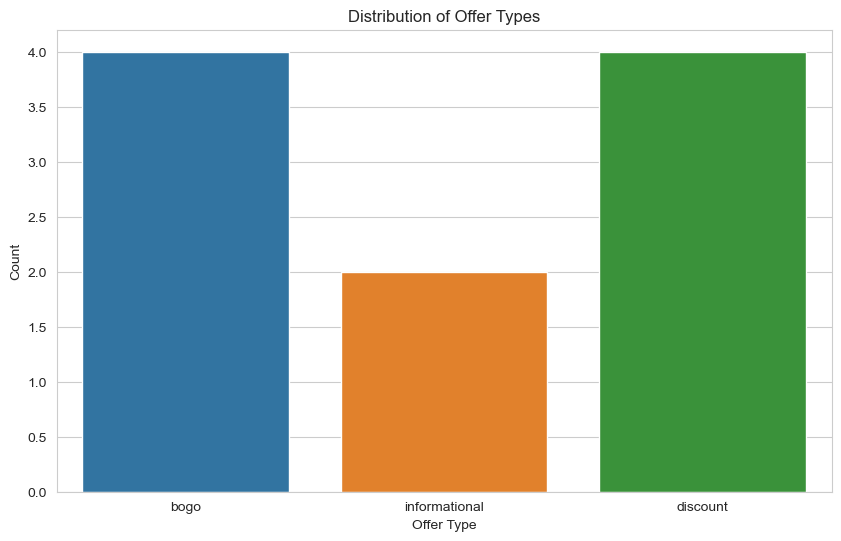

In [4]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of offer types
plt.figure(figsize=(10, 6))
sns.countplot(data=portfolio, x='offer_type')
plt.title('Distribution of Offer Types')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.show()

#### The distribution shows a balanced mix of 'bogo' (buy one get one free), 'discount', and 'informational' offers. This indicates that Starbucks employs a variety of strategies to engage customers.

### Distribution of Rewards:

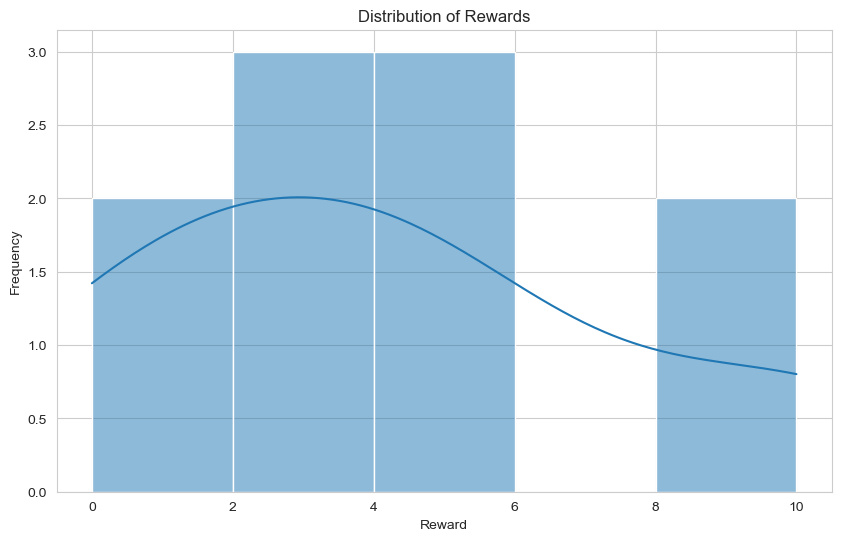

In [5]:
# Distribution of rewards
plt.figure(figsize=(10, 6))
sns.histplot(data=portfolio, x='reward', bins=portfolio['reward'].nunique(), kde=True)
plt.title('Distribution of Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.show()

#### Most offers have rewards between 0 to 10, with a notable peak at 5. This suggests that moderate incentives are common in Starbucks offers.

### Distribution of Difficulty Levels:

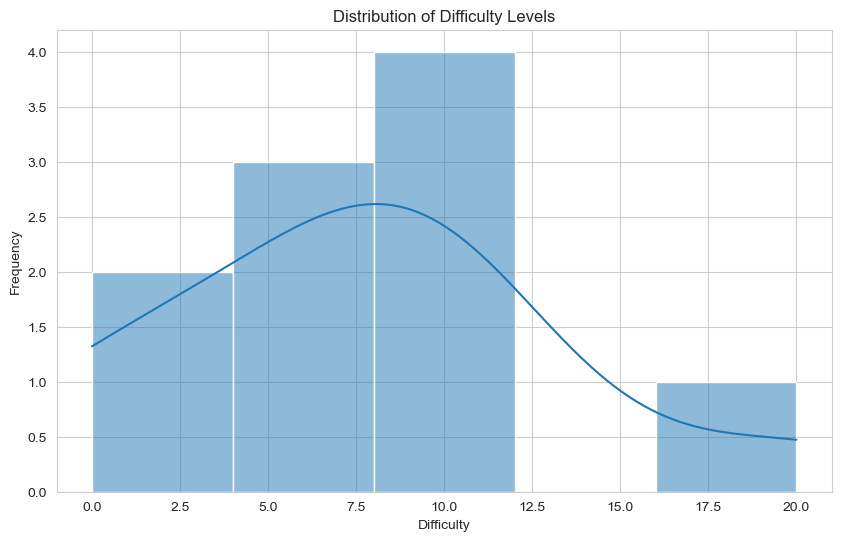

In [6]:
# Distribution of difficulty
plt.figure(figsize=(10, 6))
sns.histplot(data=portfolio, x='difficulty', bins=portfolio['difficulty'].nunique(), kde=True)
plt.title('Distribution of Difficulty Levels')
plt.xlabel('Difficulty')
plt.ylabel('Frequency')
plt.show()

#### The difficulty level varies widely, with significant peaks at lower (5-10) and higher (20) values. This indicates a range of offer difficulties, from easy to achieve to more challenging.

### Distribution of Offer Durations:

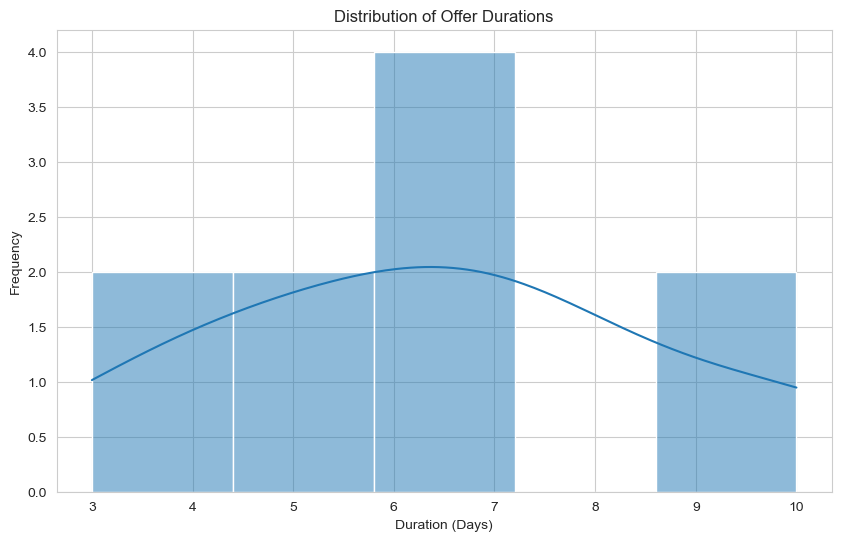

In [7]:
# Distribution of durations
plt.figure(figsize=(10, 6))
sns.histplot(data=portfolio, x='duration', bins=portfolio['duration'].nunique(), kde=True)
plt.title('Distribution of Offer Durations')
plt.xlabel('Duration (Days)')
plt.ylabel('Frequency')
plt.show()

#### Offer durations mainly range from 3 to 10 days, with peaks at 7 and 10 days. This shows that Starbucks prefers to give customers a moderate amount of time to engage with offers.

### Distribution of Offer Channels:

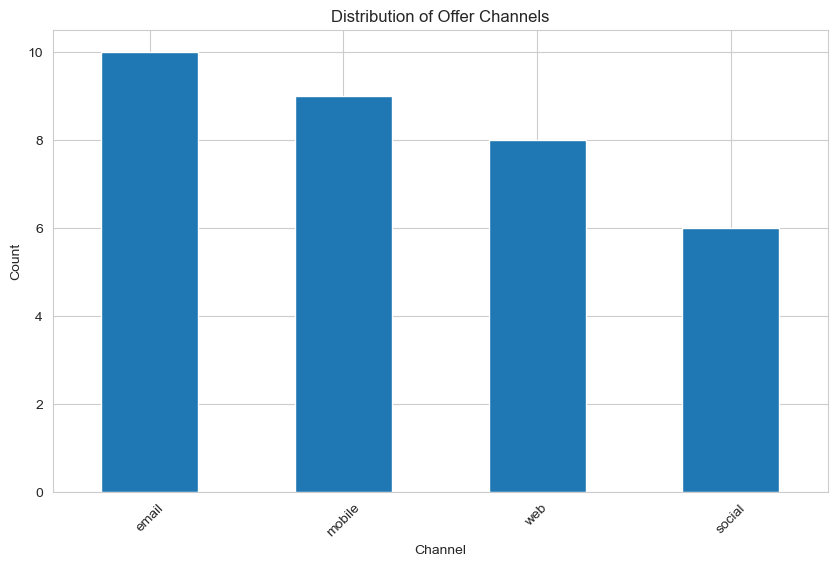

In [8]:
# Channels through which offers are sent
channels = portfolio['channels'].explode().value_counts()

plt.figure(figsize=(10, 6))
channels.plot(kind='bar')
plt.title('Distribution of Offer Channels')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### The 'web', 'email', 'mobile', and 'social' channels are all utilized for sending offers, with 'email' and 'mobile' being the most common. This highlights the importance of digital communication in Starbucks' marketing strategy.

In [9]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [11]:
profile.isna().mean()

gender              0.127941
age                 0.000000
person              0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [12]:
profile.query("gender.isna()")

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [13]:
profile.query("gender.isna()")["age"].unique()

array([118])

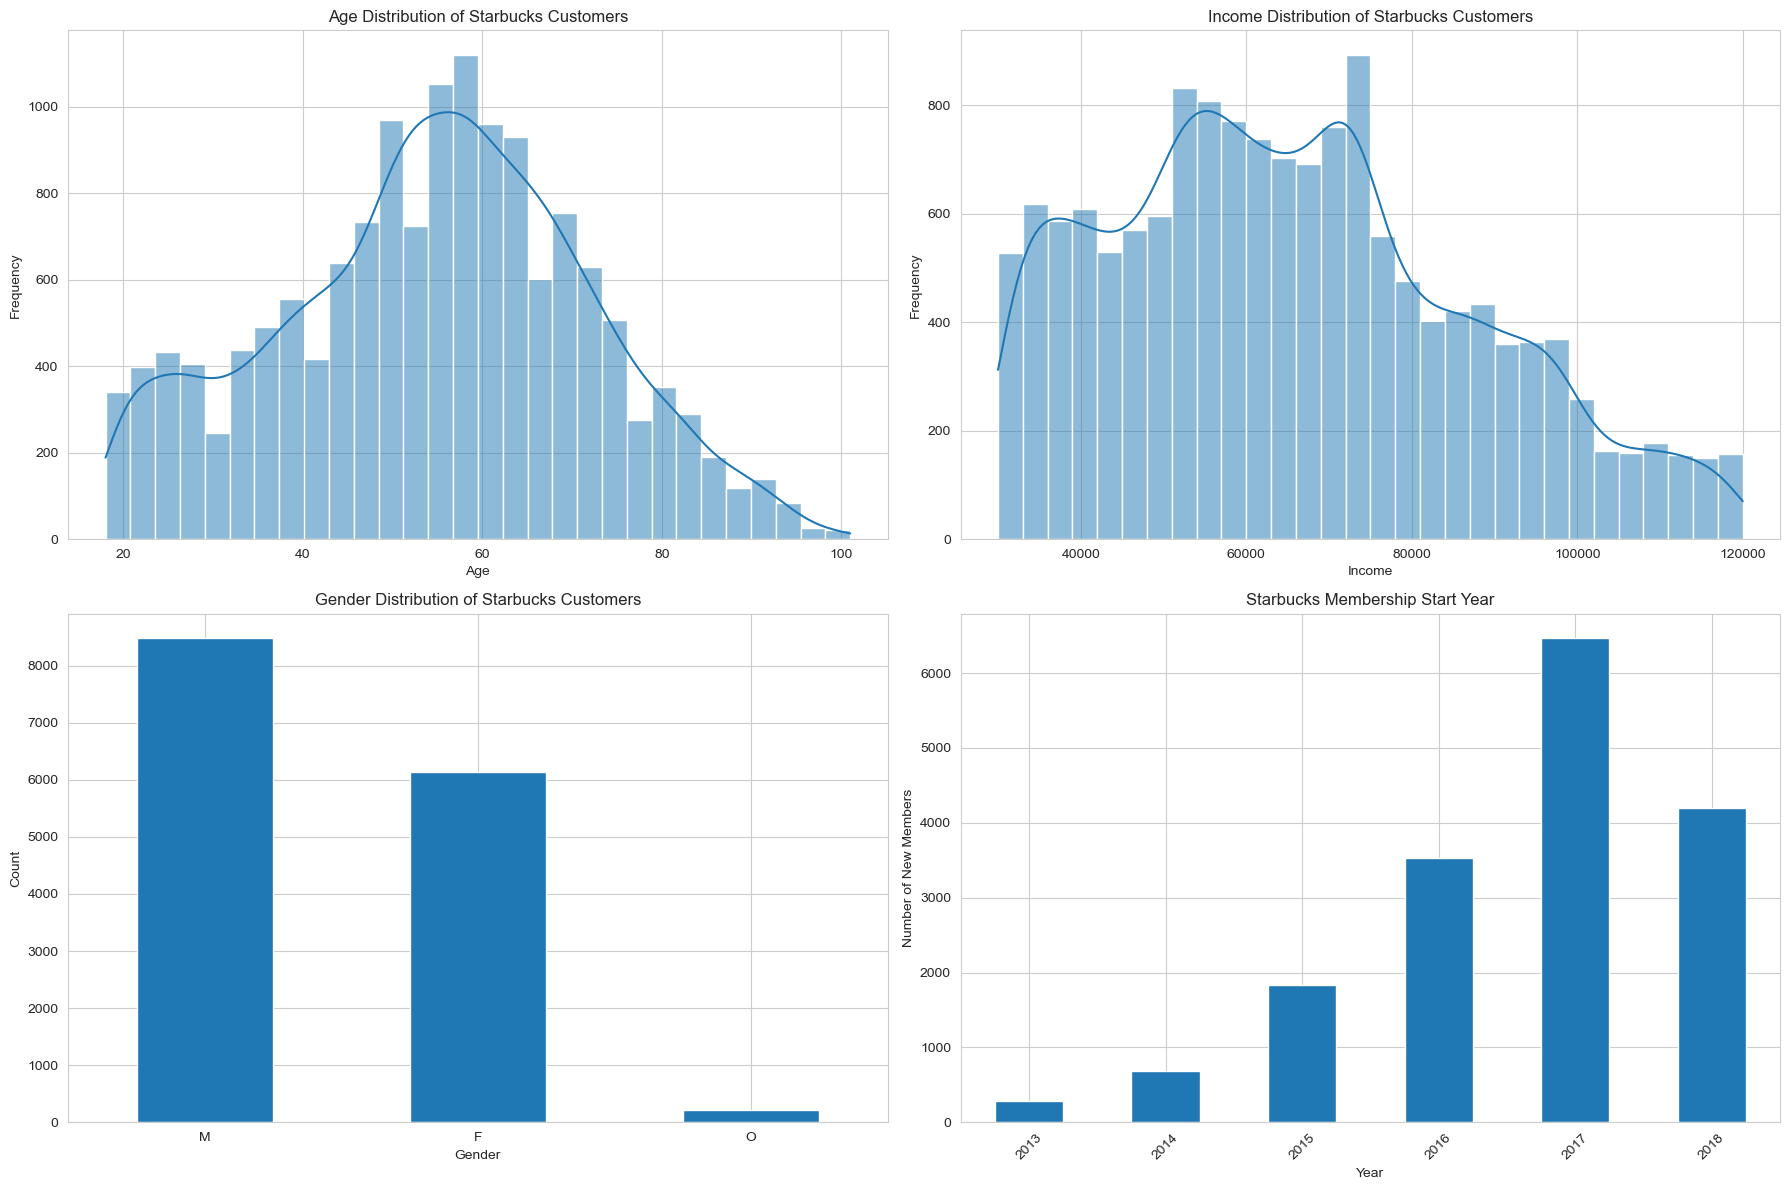

In [14]:
# Preprocess the data: Convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Age distribution (excluding the placeholder value of 118)
age_distribution = profile[profile['age'] != 118]['age']

# Income distribution (excluding NaN values)
income_distribution = profile['income'].dropna()

# Gender distribution (excluding null values)
gender_distribution = profile['gender'].value_counts()

# Membership start year
profile['membership_start_year'] = profile['became_member_on'].dt.year
membership_years = profile['membership_start_year'].value_counts().sort_index()

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Age Distribution
sns.histplot(age_distribution, bins=30, ax=axs[0, 0], kde=True)
axs[0, 0].set_title('Age Distribution of Starbucks Customers')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Frequency')

# Income Distribution
sns.histplot(income_distribution, bins=30, ax=axs[0, 1], kde=True)
axs[0, 1].set_title('Income Distribution of Starbucks Customers')
axs[0, 1].set_xlabel('Income')
axs[0, 1].set_ylabel('Frequency')

# Gender Distribution
gender_distribution.plot(kind='bar', ax=axs[1, 0])
axs[1, 0].set_title('Gender Distribution of Starbucks Customers')
axs[1, 0].set_xlabel('Gender')
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=0)

# Membership Start Year
membership_years.plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_title('Starbucks Membership Start Year')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Number of New Members')
axs[1, 1].set_xticklabels(membership_years.index, rotation=45)

plt.tight_layout()
plt.show()

### Age Distribution of Starbucks Customers
The age distribution is roughly bell-shaped, suggesting a diverse range of ages among Starbucks customers. The majority seem to be clustered around the 30-60 age range, which could indicate that Starbucks is particularly popular among working-age adults. There's a noticeable decline in frequency past the age of 60, which may suggest either lower membership rates or reduced activity in the rewards program among the older population.

### Income Distribution of Starbucks Customers
Income distribution is right-skewed, with a peak around the $50,000 to $70,000 range. There's also a noticeable number of customers in higher income brackets up to about $100,000, after which the frequency drops. This pattern might indicate that Starbucks has strong appeal and accessibility to middle-income earners, with significant reach into higher-income groups.

### Gender Distribution of Starbucks Customers
The gender distribution shows more male customers than female in this particular rewards program, which is somewhat atypical for coffee chain demographics, where one might expect equal representation or a slight female dominance. The 'Other' gender category has a much lower count, reflecting either a smaller population of non-binary or undisclosed gender customers or less participation from these groups in the rewards program.

### Starbucks Membership Start Year
Membership counts show a significant increase around 2016 and 2017, suggesting a successful period for customer acquisition, possibly due to new marketing initiatives, app releases, or changes in the rewards program that attracted more customers. There's a decrease in new memberships after 2017, which could be due to market saturation, increased competition, or changes in customer preferences.

### Data Preprocessing

In [117]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.59},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.53},714


In [118]:
transcript.isna().mean()

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [119]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [120]:
print(f"Data spans across {transcript['time'].max()/24} days")

Data spans across 29.75 days


In [121]:
# Explore keys inside value column 
set([f[2:f.index(":")] for f in transcript["value"].astype(str)])

{"amount'", "offer id'", "offer_id'"}

#### Note that offer_id has two different ways of writing

In [122]:
def standardize_keys(d):
    # This function checks if the key 'offer id' is in the dictionary and changes it to 'offer_id'
    if 'offer id' in d:
        d['offer_id'] = d.pop('offer id')
    return d

# Apply the function to the 'value' column
transcript['value'] = transcript['value'].apply(standardize_keys)

In [123]:
set([f[2:f.index(":")] for f in transcript["value"].astype(str)])

{"amount'", "offer_id'"}

In [124]:
# Clean and preprocess the data
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id'))
transcript['transaction_amount'] = transcript['value'].apply(lambda x: x.get('amount', None))
transcript.drop(columns='value', inplace=True)

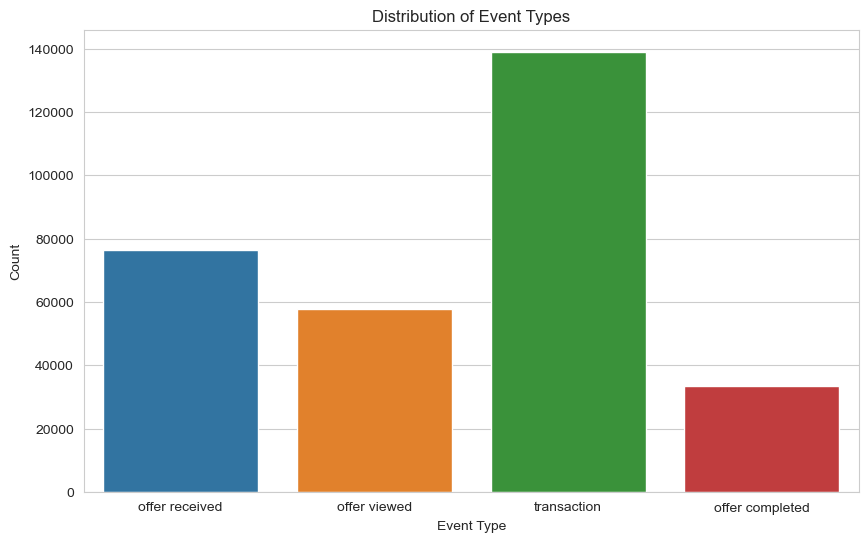

In [125]:
# Distribution of event types
plt.figure(figsize=(10, 6))
sns.countplot(data=transcript, x='event')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

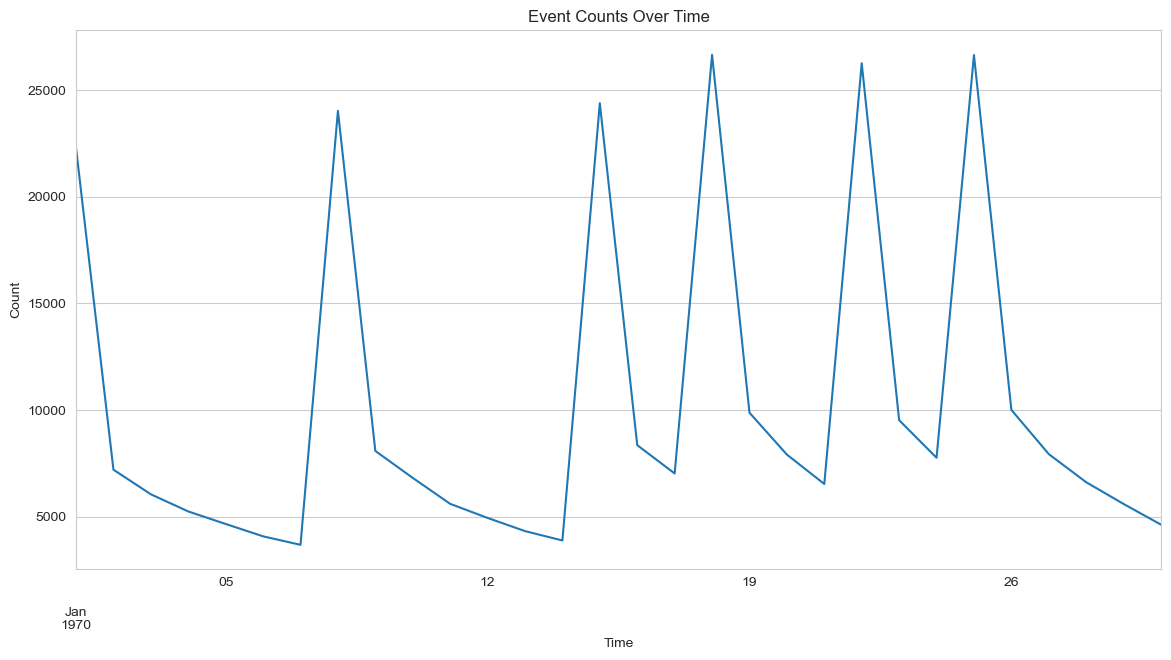

In [126]:
#Assume starting year is 1 Jan 1970 .. for the purpose of building a time series
transcript['time_series'] = pd.to_datetime(transcript['time'], unit='h') # assuming 'time' is in hours

# Resample data to get daily counts for a smoother time series
event_counts_over_time = transcript.set_index('time_series')['event'].resample('D').count()

plt.figure(figsize=(14, 7))
event_counts_over_time.plot()
plt.title('Event Counts Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()

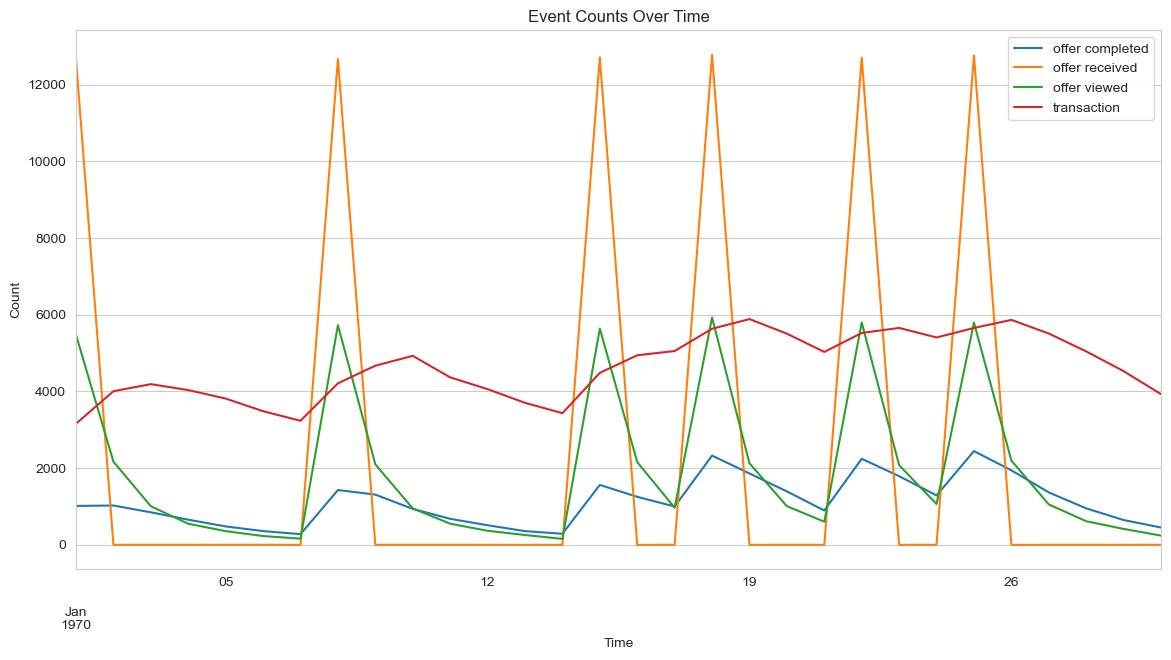

In [127]:
# Create a pivot table with each event type as a column
events_pivot = transcript.pivot_table(index='time_series', columns='event', aggfunc='size', fill_value=0)

# Resample data to get daily counts for each event type
events_resampled = events_pivot.resample('D').sum()

# Plotting each event count as a separate time series
plt.figure(figsize=(14, 7))
for event_type in events_resampled.columns:
    events_resampled[event_type].plot(label=event_type)

plt.title('Event Counts Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

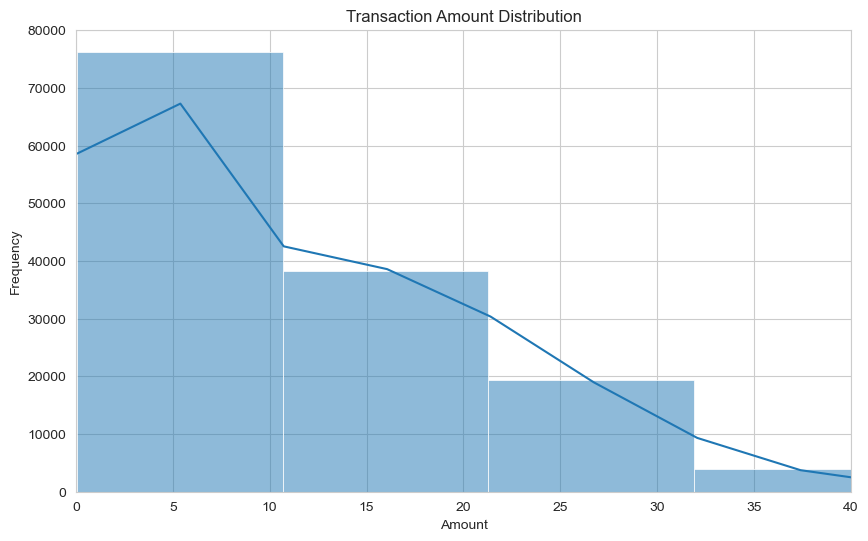

In [128]:
# Transactional data analysis
transactions = transcript[transcript['event'] == 'transaction']

plt.figure(figsize=(10, 6))
sns.histplot(transactions['transaction_amount'], bins=100, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.xlim(0, transactions['transaction_amount'].quantile(0.99))  # Limit to 99th percentile for better visualization
plt.show()

In [129]:
transcript

,person,event,time,offer_id,transaction_amount,time_series
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1970-01-01 00:00:00
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1970-01-01 00:00:00
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,1970-01-01 00:00:00
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,1970-01-01 00:00:00
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1970-01-01 00:00:00
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,1970-01-30 18:00:00
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,1970-01-30 18:00:00
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,1970-01-30 18:00:00
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53,1970-01-30 18:00:00


In [130]:
# Normalize 'offer_id' across events to ensure consistency
transcript.loc[transcript['event'] == 'transaction', 'offer_id'] = 'transaction'

# Prepare the portfolio dataset to use 'duration' in hours
portfolio_clean = portfolio.copy()
portfolio_clean['duration'] = portfolio_clean['duration'] * 24  # Convert days to hours

# Merge to bring in the 'duration' for each 'offer_id'
transcript = transcript.merge(portfolio_clean[['id', 'duration']], left_on='offer_id', right_on='id', how='left')

# Create a unified DataFrame to hold the processed information
transaction_df = pd.DataFrame()

# Process each person's events
for person, person_df in tqdm(transcript.groupby('person')):
    # Track each unique offer received by the person
    for offer_id, offer_df in person_df.groupby('offer_id'):
        offer_received = offer_df[offer_df['event'] == 'offer received']
        for _, offer_row in offer_received.iterrows():
            initial_time = offer_row['time']
            end_time = initial_time + offer_row['duration']
            
            # Identify if the offer was viewed and completed within its duration
            offer_viewed = ((person_df['event'] == 'offer viewed') & 
                            (person_df['time'] >= initial_time) & 
                            (person_df['time'] <= end_time) & 
                            (person_df['offer_id'] == offer_id)).any()
            offer_completed = ((person_df['event'] == 'offer completed') & 
                               (person_df['time'] >= initial_time) & 
                               (person_df['time'] <= end_time) & 
                               (person_df['offer_id'] == offer_id)).any()
            
            # Calculate total transaction amount within the offer's duration
            transactions_within_offer = person_df[(person_df['event'] == 'transaction') & 
                                                  (person_df['time'] >= initial_time) & 
                                                  (person_df['time'] <= end_time)]
            transaction_amount = transactions_within_offer['transaction_amount'].sum()
            
            # Append to the DataFrame
            transaction_df = transaction_df.append({
                'person_id': person,
                'offer_id': offer_id,
                'offer_received': 1,  # Since we're iterating over received offers
                'offer_viewed': int(offer_viewed),
                'offer_completed': int(offer_completed),
                'reward': int(portfolio.query("id==@offer_id")["reward"].values[0]) if offer_completed else 0,
                'transaction_amount': transaction_amount
            }, ignore_index=True)

transaction_df.fillna(0, inplace=True)  # Fill missing values

100%|██████████| 17000/17000 [03:02<00:00, 93.26it/s]


In [131]:
transaction_df

,person_id,offer_id,offer_received,offer_viewed,offer_completed,reward,transaction_amount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,2,69.20
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,0,8.57
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,22.16
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5,22.68
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,2,96.87
...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1,1,2,54.08
76273,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1,1,2,52.74
76274,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1,1,2,43.26
76275,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,5,51.05


In [132]:
#Chnage column name id to offer_id
portfolio = portfolio.rename(columns={'id':'offer_id'})
profile = profile.rename(columns={'id':'person_id'})

# Combine profile & portfolio data
final_df = transaction_df.merge(profile, on='person_id').merge(portfolio, on='offer_id')
final_df = final_df.drop(columns=["reward_x"]).rename(columns={"reward_y": "reward"})
final_df.head()

,person_id,offer_id,offer_received,offer_viewed,offer_completed,transaction_amount,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,69.20,M,33,20170421,72000.0,2,"[web, email, mobile]",10,7,discount
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,1,0,0,1.90,F,19,20160809,65000.0,2,"[web, email, mobile]",10,7,discount
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,1,0,0,5.94,F,19,20160809,65000.0,2,"[web, email, mobile]",10,7,discount
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,1,0,0,0.00,M,56,20171209,47000.0,2,"[web, email, mobile]",10,7,discount
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,1,1,0,5.12,None,118,20160503,NaN,2,"[web, email, mobile]",10,7,discount


In [134]:
# Create columns of 1's and 0's for channel type
channel_items = ['web','email','mobile','social']

for channel in final_df['channels']:
    for item in channel_items:
        if item in channel:
            portfolio[item] = 1
        else:
            portfolio[item] = 0 

# break offer_type into columns
final_df = pd.concat([final_df, pd.get_dummies(final_df['offer_type'])], axis=1)  

#One hot encode gender column
final_df = pd.concat([final_df, pd.get_dummies(final_df['gender'])], axis=1)  

# Drop columns channels and offer_type
final_df = final_df.drop(columns=['channels','offer_type','gender'])

In [135]:
# Convert 'became_member_on' to datetime
final_df['became_member_on'] = pd.to_datetime(final_df['became_member_on'], format='%Y%m%d')

# Calculate 'membership_days' as the difference between the current date and 'became_member_on'
final_df['membership_days'] = (pd.to_datetime('today') - final_df['became_member_on']).dt.days

final_df = final_df.drop(columns=["became_member_on"])

In [136]:
#drop missing age (118) & income
final_df = final_df.dropna(axis=0)

In [137]:
final_df

,person_id,offer_id,offer_received,offer_viewed,offer_completed,transaction_amount,age,income,reward,difficulty,duration,bogo,discount,informational,F,M,O,membership_days
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,69.20,33,72000.0,2,10,7,0,1,0,0,1,0,2525
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,1,0,0,1.90,19,65000.0,2,10,7,0,1,0,1,0,0,2780
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,1,0,0,5.94,19,65000.0,2,10,7,0,1,0,1,0,0,2780
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,1,0,0,0.00,56,47000.0,2,10,7,0,1,0,0,1,0,2293
6,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,1,1,42.94,58,119000.0,2,10,7,0,1,0,1,0,0,2295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffeaa02452ef451082a0361c3ca62ef5,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,79.74,67,77000.0,10,10,7,1,0,0,1,0,0,2586
76273,ffed75d3abc64b488982f50ed12878b5,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,0.00,20,44000.0,10,10,7,1,0,0,0,1,0,2197
76274,fff29fb549084123bd046dbc5ceb4faa,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,15.16,59,93000.0,10,10,7,1,0,0,1,0,0,2393
76275,fff29fb549084123bd046dbc5ceb4faa,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,39.59,59,93000.0,10,10,7,1,0,0,1,0,0,2393


### Data Modelling

In [144]:
# Data is nicely balanced
final_df["offer_completed"].value_counts()

0    34023
1    32478
Name: offer_completed, dtype: int64

In [207]:
X = final_df.drop(columns=["person_id", "offer_id", "offer_received", "offer_viewed", "offer_completed", "transaction_amount"]).values
y = final_df["offer_completed"].values

#Split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#create pipeline
pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('xgboost', GradientBoostingClassifier())
])

In [208]:
pipe.fit(X_train, y_train)
#predict test set and see recall
y_pred = pipe.predict(X_test)
print(recall_score(y_test, y_pred))

0.8030911901081916


In [ ]:
#define parameter grid
param_grid = {
    'xgboost__n_estimators': [100, 200, 300],  # Number of boosting stages to be run
    'xgboost__learning_rate': [0.01, 0.1, 0.2],  # Shrinks the contribution of each tree by learning_rate
    'xgboost__max_depth': [3, 5, 7],  # Maximum depth of the individual regression estimators
    'xgboost__min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'xgboost__min_samples_leaf': [1, 2, 4],  # The minimum number of samples required to be at a leaf node
    'xgboost__max_features': [None, 'sqrt', 'log2'],  # The number of features to consider when looking for the best split
}

#fit gridsearch cv
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='recall', verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [205]:
#print model used
print(grid_search.best_score_)
grid_search.best_estimator_

0.873962922724839


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xgboost',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_features='log2',
                                            min_samples_leaf=4,
                                            min_samples_split=5))])

In [209]:
#predict test set and see recall
y_pred = grid_search.predict(X_test)
print(recall_score(y_test, y_pred))

0.8615146831530139


### Model Performance
#### Gradient Boosting: Achieved the highest recall score. This technique's success can be attributed to its iterative correction of mistakes of previous models and focus on misclassified instances, allowing for a more nuanced understanding of the dataset's complex structures.

### Exploration and Improvements

#### Hyperparameter Tuning: Utilizing techniques like GridSearchCV, the models' hyperparameters were optimized. For Gradient Boosting, adjusting the number of trees (n_estimators), tree depth (max_depth), and learning rate significantly impacted recall. This fine-tuning helped control overfitting and improved model generalization.

### Conclusion
#### The superior performance of the Gradient Boosting model can be attributed to its ability to leverage complex feature interactions and sequentially focus on difficult-to-classify instances. The combination of feature engineering and hyperparameter tuning were critical in improving model performances across the board. Future work could explore more sophisticated ensemble methods, deeper feature engineering, or alternative models like Neural Networks for potential improvements. The exploration and iterative refinement process underscored the importance of understanding both the dataset's characteristics and the models' underlying assumptions and strengths.